# GopherAnalysis

Here, I quantitatively describe the expected behavior of MotifGopher's substring-finding algorithm. This algorithm finds all substrings that appear in texts in a corpus with frequency at least equal to `thresh`.

It is intended to take near-constant time wrt corpus size, but I have been unable to prove any meaningful bound on its actual time complexity because it is a Monte Carlo algorithm whose behavior depends on many parameters and many characteristics of the corpus.

## The Algorithm

The algorithm is as follows:

Initialize the set of excluded substrings to be the empty set.

For $N$ times, do:

1. Select a text from the corpus uniformly at random.

1. Select a position $i$ in that text uniformly at random. Define $s$ to be the substring of geometrically distributed length with parameter $r$ whose first character is $i$. (Obviously, $s$ is truncated as needed if $i$ is at the end of the text.)

1. If $s$ is in the set of excluded substrings, continue. Else, do:

    1. Define $k$ to be equal to some constant $m$. Until $s$ is determined with confidence level at least `confidence` to appear in the corpus with frequency at least `thresh`, do:
        1. Take a uniform sample with replacement of size $k$ from the corpus -- or if $k$ is at least the size of the corpus, sample the entire population without replacement.
        1. Use this sample to determine a CI (or an exact value, if the entire population was sampled) for the true frequency $f$ of $s$ in the corpus, and use this CI to determine if $f \geq$ `thresh`.
        1. Scale $k$ by some large constant factor $R$.

    1. If $s$ is determined to appear with frequency at least `thresh`, include it in the set of common substrings. Otherwise, put it in the set of explicitly excluded substrings.

## The Dataset

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
with open(os.path.join('..', '..', 'datasets', 'occ_45K.pickle'), 'rb') \
        as dbfile:
    texts = list(pickle.load(dbfile).raw)
print('Mean text length:', sum(len(text) for text in texts) / len(texts))

Mean text length: 217.0882507212169


## Probability of Being Found $\mathbb{P}[F_s]$ for a String $s$

I consider substring $s$, of length $\ell$, that appears citations in the corpus with frequency $f$. $r$ is the parameter of the geometric distribution of found substring lengths. $N$ hunt operations are performed. $L$ is the maximum length of any text in which $s$ appears. The calculations that follow use the assumption that $\ell \ll L$.

I consider the case in which $s$ appears at most one time in a given citation. Then, the probability that it is found in one hunt operation is as follows:

$$  f\frac{1}{L}\left( r^{\ell-1} (1-r) \right)  $$

Precise calculation of the proability that $s$ is found given that it can appear arbitrarily many times in a given citation is more difficult, but it can be upper-bounded by

$$ f\left( r^{\ell-1} (1-r) \right) $$

Distinct hunt operations are independent of each other, so we can conclude that

$$ 1 - \left(1 - \frac{f}{L}\left( r^{\ell-1} (1-r) \right)\right)^N \leq \mathbb{P}[F_s] \leq 1 - \left(1 - f\left( r^{\ell-1} (1-r) \right)\right)^N $$

## Probability of Incorrect Inclusion $\mathbb{P}[I_s]$ of a String $s$

Let $R$ be the factor by which sample size is scaled when there is a failure to determine whether a word should be included or excluded, let $M$ be the size of the corpus, and let $m$ be the initial sample size to be taken.

We have that

$$\mathbb{P}[I_s] \leq \mathbb{P}[F_s](1-\text{confidence}^{\lfloor \log_R M/m \rfloor})$$

I will assume the MotifGopher is run with `thresh = 0.1`, `confidence=0.99`, `r=0.75`, and that the substring of interest $s$ has a borderline frequency -- that is, that $f \approx $ `thresh`. I further assume that $\log_R M/m$ is not greater than $5$. In the case that $R=10$, this is equivalent to the assumption that $M$ is not more than $5$ orders of magnitude larger than $m$.

What follows is a plot of an upper bound on the probability of incorrect inclusion, as a function of the length $\ell$ of $s$. The value of the bound is nearly equal to $(1-\text{confidence}^{\lfloor \log_R M/m \rfloor})$ over the domain of interest.

In [ ]:
thresh = 0.1
confidence = 0.99
r = 0.75
f = thresh
maxLogRM = 5
N = 400000
L = np.percentile([len(text) for text in texts], 95)
L

316.0

I note that $N=4\times 10^5$ is a large number of times to search for new substrings, but not an unrealistically large number. From experience, I estimate that the program when run with this parameter and with the corpus size $M=35000$ would take on the order of a several hours to terminate.

I also note that about $10^2$ times as many substrings would be examined if a fully comprehensive search for substrings of length up to about 6 were taken on a similar dataset. It is not completely clear that this would translate into $10^2$ times the runtime, since substrings whose frequencies have already been estimated do not have their frequencies estimated twice, but it is true that much more space would be used.

In [ ]:
def minPFound(f, L, r, l, N):
    return 1 - (1 - (f/L)*(r**(l - 1) * (1 - r)))**N
def maxPFound(f, L, r, l, N):
    return minPFound(f, 1, r, l, N)

In [ ]:
max_l = 10
lengths = np.arange(1, max_l + 1)
probabilities = np.zeros(max_l)
for i, l in enumerate(lengths):
    probabilities[i] = \
        maxPFound(f, L, r, l, N) * (1 - confidence**maxLogRM)

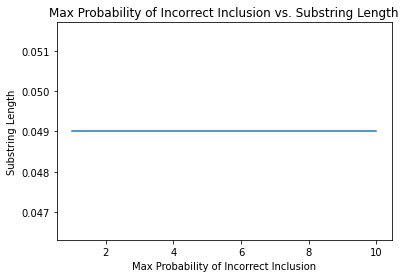

In [ ]:
plt.plot(lengths, probabilities)
plt.title('Max Probability of Incorrect Inclusion vs. Substring Length')
plt.ylabel('Substring Length')
plt.xlabel('Max Probability of Incorrect Inclusion');

## Probability of Incorrect Exclusion $\mathbb{P}[E_s]$ of a String $s$

We have that

$$\mathbb{P}[E_s] \leq (1 - \mathbb{P}[F_s]) + \mathbb{P}[F_s](1-\text{confidence}^{\lfloor \log_R M/m \rfloor})$$

Where the first term comes from the possibility that the substring is never even examined.

What follows is a plot of an upper bound on the probability of incorrect exclusion, as a function of the length $\ell$ of $s$. For most of the domain of interest, the value of the bound is dominated by the second term The value of the bound is dominated by the first term, particularly the factor $(1-\text{confidence}^{\lfloor \log_R M/m \rfloor})$. For long substrings, the value of the found is dominated by the first term $(1 - \mathbb{P}[F_s])$, which approaches $1$ as $\ell$ increases.

In [ ]:
max_l = 10
lengths = np.arange(1, max_l + 1)
probabilities = np.zeros(max_l)
for i, l in enumerate(lengths):
    probabilities[i] = (1 - minPFound(f, L, r, l, N)) \
        + maxPFound(f, L, r, l, N) * (1 - confidence**maxLogRM)

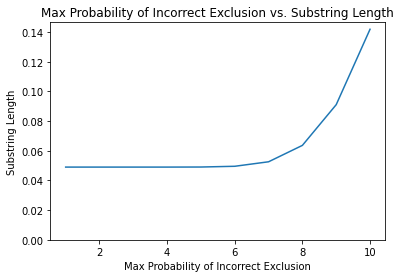

In [ ]:
plt.plot(lengths, probabilities)
plt.ylim(ymin=0)
plt.title('Max Probability of Incorrect Exclusion vs. Substring Length')
plt.ylabel('Substring Length')
plt.xlabel('Max Probability of Incorrect Exclusion');

In [ ]:
probabilities

array([0.04900995, 0.04900995, 0.04900997, 0.04901154, 0.04905476,
       0.04955769, 0.05259038, 0.06364705, 0.09109163, 0.14192174])

This shows that $N$ and $M$ can and should be tuned according to the whether there truly are common substrings that are not very short. However, even with a rather large $N$, far fewer substrings are taken as candidates for inclusion than would be in the naive approach.

## Time Complexity

I have had difficulty analyzing time complexity. In the worst case, where every single substring that could be possibly found in the corpus appears with exactly the threshold frequency, the time complexity is $O(MN)$, where $M$ is the corpus size and $N$ is the number of searches conducted for new substrings. In the best case, the time complexity is $\Omega(N)$, because samples of constant size $m$ are always taken to determine how common certain substrings are, and it is assumed that none of the texts in the corpus are too long. I believe that the algorithm should be closer to the lower bound in realistic cases, but it is difficult for me to know and it is difficult to do experiments because the algorithm is so slow.